In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re,os,time, math, gdal, argparse
from shutil import copyfile
import matplotlib.pyplot as plt
from PIL import Image

## tif load test

In [2]:
df_state24 = pd.read_csv('/home/timhu/data/state24_jpgpaths_clean_17k_May14.csv')
IMG_DIR = '/home/timhu/data'

In [3]:
def load_tif_from_file(file, crop_width, crop_height):
    img_file = gdal.Open(file)
    width, height = img_file.RasterXSize, img_file.RasterYSize
    if crop_width > width:
        raise Exception("Requested width exceeds tif width.")
    if crop_height > height:
        raise Exception("Requested height exceeds tif height.")  
    # returns np array of shape (C, H, W)
    img_data = img_file.ReadAsArray((width - crop_width)//2, (height - crop_height)//2, crop_width, crop_height) 
    img_data = np.moveaxis(img_data, 0, -1)
    
    return img_data

In [7]:
i = 444
Wl8 = Hl8 = 150 # Landsat 30m resolution per pixel
Ws1 = Hs1 = 450 # Sentinel-1 10m resolution per pixel
l8_path = os.path.join(IMG_DIR, df_state24.l8_vis_path[i])
s1_path = os.path.join(IMG_DIR, df_state24.s1_vis_path[i])
# print(df_state24.pop_density_class[i])

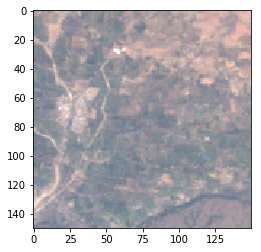

In [8]:
img_data = load_tif_from_file(l8_path, Wl8, Hl8)
plt.imshow(img_data)

In [6]:
img_data = load_tif_from_file(s1_path, Ws1, Hs1)
plt.imshow(img_data)

AttributeError: 'NoneType' object has no attribute 'RasterXSize'

## Night light load test

In [31]:
# from PIL import Image
import matplotlib.image as mpimg
path = "/home/timhu/all_jpg/nl_median_india_vis/nl_median_india_vis_5x5_453544.0.jpg"
im = mpimg.imread(path)
im

array([[1, 5, 8, 8, 6],
       [3, 5, 7, 6, 3],
       [5, 6, 6, 4, 1],
       [5, 5, 4, 3, 1],
       [5, 4, 3, 2, 3]], dtype=uint8)

## CNN input test

In [5]:
import vgg_deep_combo as vgg
import tensorflow.contrib.slim as slim

import data_input_jpg as dataset

In [6]:
# input image dimensions, used for image preprocessing before CNN model
IMAGE_HEIGHT = 224 
IMAGE_WIDTH = 224 
IMAGE_CHANNEL = 6

MODEL = 'vgg'
PRETRAIN_WEIGHTS = '/home/timhu/weights/vgg_16.ckpt'

# Basic model parameters as external flags.
FLAGS = argparse.Namespace(learning_rate= 1e-6,
                           lr_decay_rate = 1e-2, # exponential learning rate decay 
                           dropout_keep= 0.8, 
                           max_epoch = 30, # maximum number of epoch
                           batch_size= 64, 
                           output_size = 1) # class number = 1 for regression output

# input traning data
# ANNOS_CSV = '/home/timhu/dfd-pop/data/annos_csv/state24_jpgpaths_density_nolaps_12k_Mar8.csv'
ANNOS_CSV = '/home/timhu/data/state24_jpgpaths_clean_17k_May17.csv'
JPG_DIR = '/home/timhu/data/all_jpg/'
DATA = 'l8s1nl'
df_annos = pd.read_csv(ANNOS_CSV, index_col=0)

In [7]:
# create input path and labels np.array from csv annotations
df_annos = pd.read_csv(ANNOS_CSV, index_col=0)
df_annos = df_annos.sample(frac=1).reset_index(drop=True) # shuffle the whole datasets

path_col = ['l8_vis_jpg', 's1_vis_jpg']

input_files_train = JPG_DIR + df_annos.loc[df_annos.partition == 'train', path_col].values
input_labels_train = df_annos.loc[df_annos.partition == 'train', 'pop_density_log2'].values
input_files_val = JPG_DIR + df_annos.loc[df_annos.partition == 'val', path_col].values
input_labels_val = df_annos.loc[df_annos.partition == 'val', 'pop_density_log2'].values

# input_nljpg_train = JPG_DIR + df_annos.loc[df_annos.partition == 'train', 'nl_vis_jpg'].values
# input_nljpg_val = JPG_DIR + df_annos.loc[df_annos.partition == 'val', 'nl_vis_jpg'].values

input_id_train = df_annos.loc[df_annos.partition == 'train', 'village_id'].values
input_id_val = df_annos.loc[df_annos.partition == 'val', 'village_id'].values

print('input_files_train shape:', input_files_train.shape)
# print('input_nljpg_train shape:', input_nljpg_train.shape)

train_set_size = len(input_labels_train)

input_files_train shape: (10884, 2)


In [13]:
tf.reset_default_graph()
sess = tf.Session() # config=tf.ConfigProto(log_device_placement=True)) 

with tf.device('/cpu:0'):
        train_images_batch, train_labels_batch, train_id_barch = \
        dataset.input_batches(FLAGS.batch_size, FLAGS.output_size, input_files_train, input_labels_train, input_id_train,
                              IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL, 
                              regression=True, augmentation=False, normalization=False)
        val_images_batch, val_labels_batch, val_id_barch = \
        dataset.input_batches(FLAGS.batch_size, FLAGS.output_size, input_files_val, input_labels_val, input_id_val, 
                              IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL, 
                              regression=True, augmentation=False, normalization=False)


images_l8_placeholder = tf.placeholder(tf.float32, shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, 3]) 
images_s1_placeholder = tf.placeholder(tf.float32, shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, 3])
# vectors_nl_placeholder = tf.placeholder(tf.float32, shape=[None, 25])
labels_placeholder = tf.placeholder(tf.float32, shape=[None,])
print('finish data input')

TRAIN_BATCHES_PER_EPOCH = int(train_set_size / FLAGS.batch_size) # number of training batches/steps in each epoch
MAX_STEPS = TRAIN_BATCHES_PER_EPOCH * FLAGS.max_epoch # total number of training batches/steps

# CNN forward reference
if MODEL == 'vgg':
    outputs, _ = vgg.vgg_16(images_l8_placeholder, images_s1_placeholder, # inputs_nl=vectors_nl_placeholder,
                            num_classes=FLAGS.output_size, dropout_keep_prob=FLAGS.dropout_keep, is_training=True)
    outputs = tf.squeeze(outputs) # change shape from (B,1) to (B,), same as label input

finish data input


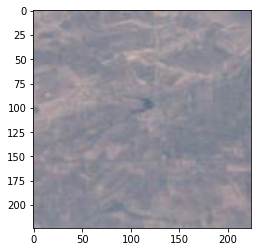

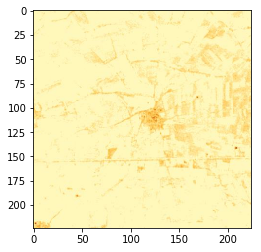

label: (64,)
image: (64, 224, 224, 6)
True pop log2: 7.45384559244
village_id: 448013


,latitude,longitude
1741,22.582602,71.900932


In [32]:
i = 12
images_out, labels_out, id_out = sess.run([train_images_batch, train_labels_batch, train_id_barch])
plt.imshow(images_out[i][:,:,:3])
# plt.imshow(curr_image_batch[12].astype(np.uint8))
plt.show()
plt.imshow(images_out[i][:,:,3:])
# plt.imshow(curr_image_batch[12].astype(np.uint8))
plt.show()
print('label:', labels_out.shape)
print('image:', images_out.shape)
# print('night light:')
# print(nl_out[i].reshape((5,5)))
print('True pop log2:', labels_out[i])
print('village_id:', id_out[i])
df_annos.loc[df_annos.village_id == id_out[i],['latitude','longitude']]

In [33]:
df_annos.loc[df_annos.village_id == id_out[i]]

,village_id,state_id,district_id,subdistrict_id,secc_pop,secc_pop_scaled,area,longitude,latitude,pop_density,pop_density_log2,partition,l8_vis_path,s1_vis_path,l8_vis_jpg,s1_vis_jpg
1741,448013,24,475,3797,2555,2233.550021,1.457336e+07,71.900932,22.582602,175.319856,7.453846,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...


In [16]:
# feed_dict = {images_placeholder: curr_image_batch, labels_placeholder: curr_label_batch}
# train_outputs = sess.run(outputs, feed_dict=feed_dict)
# train_outputs.shape

## jpg convertion test

In [35]:
JPG_DIR = '/home/timhu/all_jpg'

In [36]:
df_state24.head()

,Unnamed: 0,village_id,state_id,secc_pop,secc_pop_scaled,area,longitude,latitude,pop_density,pop_density_log2,pop_density_log2_int,pop_density_class,partition,l8_vis_path,s1_vis_path
0,0,442056,24,901,808.950004,6.645771e+06,68.663873,23.787009,135.574930,7.082947,7,6,val,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...
1,1,442057,24,492,427.650002,1.705644e+07,68.699879,23.782466,28.845417,4.850270,4,3,val,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...
2,3,442059,24,288,249.200002,5.765201e+06,68.771516,23.794030,49.954891,5.642554,5,4,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...
3,4,442060,24,548,476.600004,1.800210e+07,68.764880,23.817557,30.440892,4.927939,4,3,val,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...
4,5,442061,24,972,846.250010,5.488611e+07,68.834434,23.789144,17.709398,4.146443,4,3,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...


In [41]:
for i in range(10):
    l8_path = os.path.join(IMG_DIR, df_state24.l8_vis_path[i])
    l8_jpg = re.sub('tif', 'jpg', l8_path)
    l8_jpg = re.sub('500x500', '150x150', l8_jpg)
    img_data = load_tif_from_file(l8_path, Wl8, Hl8)
    im = Image.fromarray(img_data) 
    im.save(os.path.join(JPG_DIR, l8_jpg), format='JPEG')

## train/val distribution check

In [28]:
ANNOS_CSV = '/home/timhu/dfd-pop/data/annos_csv/state24_jpgpaths_density_nolaps_12k_Mar8.csv'
df_annos = pd.read_csv(ANNOS_CSV, index_col=0)

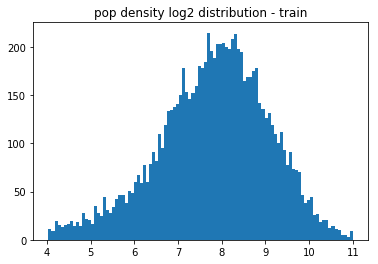

In [137]:
# train
n, bins, patches = plt.hist(df_annos.loc[df_annos.partition == 'train', 'pop_density_log2'].values, bins=100)
plt.title('pop density log2 distribution - train')

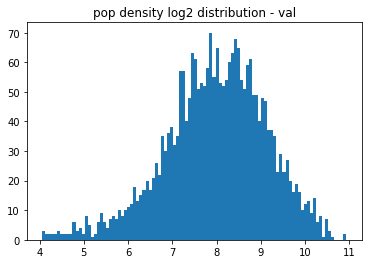

In [136]:
# val
n, bins, patches = plt.hist(df_annos.loc[df_annos.partition == 'val', 'pop_density_log2'].values, bins=100)
plt.title('pop density log2 distribution - val')

## night light regression

In [31]:
import matplotlib.image as mpimg
ANNOS_CSV = '/home/timhu/dfd-pop/data/annos_csv/state24_jpgpaths_density_nolaps_12k_Mar8.csv'
JPG_DIR = '/home/timhu/all_jpg/'
df_annos = pd.read_csv(ANNOS_CSV, index_col=0)

In [38]:
# create a list of nl paths
nl_list = []
for (i, row) in df_annos.iterrows() :
    nl_list.append(JPG_DIR + row.nl_vis_jpg)

In [44]:
# create a list of nl value [array(25,)]
nl_values_list = []
for path in nl_list:
    im = mpimg.imread(path).reshape(-1)
    nl_values_list.append(im)

In [49]:
# nl value matrix array(N, 25)
nl_values = np.stack(nl_values_list, axis=0)
# sum of nl for each village array(N,)
nl_sum = np.sum(nl_values, axis=1)

In [77]:
# build dataframe
df = pd.DataFrame(nl_values)
df['nl_sum'] = nl_sum
df['density_log2'] = df_annos.pop_density_log2.values
df['density'] = df_annos.pop_density.values
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,nl_sum,density_log2,density
0,27,24,19,14,10,25,22,18,13,9,...,9,5,17,15,11,7,4,375,7.082947,135.574930
1,6,3,0,0,0,6,3,0,0,0,...,0,0,6,3,0,0,0,45,4.850270,28.845417
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.642554,49.954891
3,1,1,2,3,4,0,0,1,2,3,...,0,0,0,0,0,0,0,19,4.927939,30.440892
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.146443,17.709398


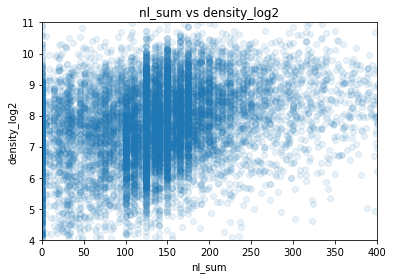

correlation: 0.204386625873


In [74]:
import matplotlib.pyplot as plt
# nl_sum vs density_log2
plt.plot(df.nl_sum.values, df.density_log2.values,'o', alpha=0.1)
plt.axis([0, 400, 4, 11])
plt.title('nl_sum vs density_log2')
plt.xlabel('nl_sum')
plt.ylabel('density_log2')
plt.show()
print('correlation:',np.corrcoef(df.nl_sum.values, df.density_log2.values)[0,1])

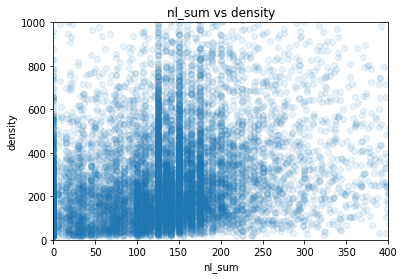

correlation: 0.201543721046


In [75]:
# nl_sum vs density
plt.plot(df.nl_sum.values, df.density.values,'o',alpha=0.1)
plt.axis([0, 400, 0, 1000])
plt.title('nl_sum vs density')
plt.xlabel('nl_sum')
plt.ylabel('density')
plt.show()
print('correlation:',np.corrcoef(df.nl_sum.values, df.density.values)[0,1])

In [98]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

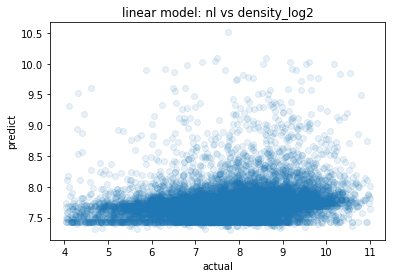

correlation: 0.216055252655
R2: -19.4244381842


In [135]:
X = df[df.columns[range(25)]].values
Y = df.density_log2.values
# regr = linear_model.LinearRegression()
regr = linear_model.Ridge(alpha = 1)
regr.fit(X, Y)
y = regr.predict(X)
plt.plot(Y, y,'o',alpha=0.1)
plt.title('linear model: nl vs density_log2')
plt.xlabel('actual')
plt.ylabel('predict')
plt.show()
print('correlation:',np.corrcoef(y, Y)[0,1])
print('R2:', r2_score(y, Y))

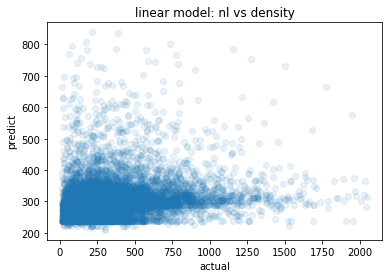

correlation: 0.208959284955
R2: -20.9037149109


In [108]:
X = df[df.columns[range(25)]].values
Y = df.density.values
# regr = linear_model.LinearRegression()
regr = linear_model.Ridge(alpha = 0.8)
regr.fit(X, Y)
y = regr.predict(X)
plt.plot(Y, y,'o',alpha=0.1)
plt.title('linear model: nl vs density')
plt.xlabel('actual')
plt.ylabel('predict')
plt.show()
print('correlation:',np.corrcoef(y, Y)[0,1])
print('R2:', r2_score(y, Y))